In [193]:
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt

# Loading base images and coverting them to grayscale
face = cv2.imread("bonoro.jpeg")
body = cv2.imread("boulos.png")

face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
body_gray = cv2.cvtColor(body, cv2.COLOR_BGR2GRAY)

# Create empty matrices in the images' shapes
height, width = face_gray.shape
mask = np.zeros((height, width), np.uint8)

height, width, channels = body.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)

In [194]:
# Loading models and predictors of the dlib library to detect landmarks in both faces
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")

# Getting landmarks for the face that will be swapped into to the body
rect = detector(face_gray)[0]

# This creates a with 68 pairs of integer values — these values are the (x, y)-coordinates of the facial structures 
landmarks = predictor(face_gray, rect)
landmarks_points = [] 

def get_landmarks(landmarks, landmarks_points):
  for n in range(68):
      x = landmarks.part(n).x
      y = landmarks.part(n).y
      landmarks_points.append((x, y))

get_landmarks(landmarks, landmarks_points)

points = np.array(landmarks_points, np.int32)


The Convex Hull of a shape or a group of points is a tight fitting convex boundary around the points or the shape, we are using this to generate a mask around the landmark point over the subject's face

https://www.learnopencv.com/convex-hull-using-opencv-in-python-and-c/

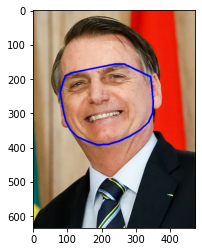

In [195]:
convexhull = cv2.convexHull(points) 

face_cp = face.copy()
plt.imshow(cv2.cvtColor((cv2.polylines(face_cp, [convexhull], True, (255, 0, 0), 3)), cv2.COLOR_BGR2RGB))
# cv2.fillConvexPoly(mask, convexhull, 255)

face_image_1 = cv2.bitwise_and(face, face, mask=mask)

In [179]:
def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

rect = cv2.boundingRect(convexhull)

subdiv = cv2.Subdiv2D(rect)
subdiv.insert(landmarks_points)



In [135]:
face_gray.shape

(640, 640)

In [ ]:
# https://www.pyimagesearch.com/2019/12/16/training-a-custom-dlib-shape-predictor/